### 0 Research Notes
- Seq 2 Seq model.
    - https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- Attention
    - https://github.com/keras-team/keras/issues/4962
- Seq 2 Seq model with Attn.
    - https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a
    - https://arxiv.org/pdf/1409.0473.pdf
    - https://arxiv.org/pdf/1508.04025.pdf
- Saving & Reloading Hidden States
    - https://stackoverflow.com/questions/57611085/how-to-save-and-reload-hidden-states-of-keras-encoder-decoder-model-for-inferenc
- Embedding Size Rule
    -  https://forums.fast.ai/t/embedding-layer-size-rule/50691

### 1 Library Import

In [1]:
import pandas as pd
import numpy as np
import re
import pickle

from collections import defaultdict
import ast

from numpy import array
from numpy import argmax
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Embedding, Input, TimeDistributed, Activation
from tensorflow.keras.layers import MaxPooling1D, SpatialDropout1D, Dropout, Concatenate, Flatten, RepeatVector, Permute
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Multiply, Lambda
from tensorflow.keras.backend import sum as Ksum

from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.utils import plot_model

### 2 Data

#### 2.1 Data Load

In [2]:
labeled_data_df=pd.read_csv('labeled_data.txt',sep='|')
labeled_data_df[['Addresses']]=pd.DataFrame(labeled_data_df['Addresses'].apply(lambda t:ast.literal_eval(t)))
labeled_data_df[['Notice']]=pd.DataFrame(labeled_data_df['Notice'].apply(lambda t:t.replace('\n',' ')))
labeled_data_df[['Notice']]=pd.DataFrame(labeled_data_df['Notice'].apply(lambda t:' '.join(t.split())))

In [3]:
def unnest(df, tile, explode):
    vals = df[explode].sum(1)
    rs = [len(r) for r in vals]
    a = np.repeat(df[tile].values, rs, axis=0)
    b = np.concatenate(vals.values)
    d = np.column_stack((a, b))
    return pd.DataFrame(d, columns = tile +  ['_'.join(explode)])
def join_textseq(seq_list, delim_char='|'):
    return delim_char.join(seq_list)

In [4]:
data_df=labeled_data_df.copy(deep=True)

In [5]:
data_df['Addresses']=labeled_data_df['Addresses'].apply(lambda l:list(l)).apply(lambda l:join_textseq(l))

#### 2.2 Feature Dictionary

In [21]:
## Add hash and dash sign as well
features='1234567890abcdefghijklmnopqrstuvwxyz <>|'
feature_dict=defaultdict(int)
count=0
for f in features:
    count+=1
    feature_dict[f] += count # increment element's value by 1

inv_feature_dict = {v: k for k, v in feature_dict.items()}

num_tokens=len(features)+1

In [ ]:
feature_dict['_']=0

In [57]:
inv_feature_dict[0]='_'

#### 2.3 Utility Functions

In [16]:
def encode_label_seq(text, feature_dict=feature_dict, start_char='<',end_char='>'):
    code=[]
    text=text.lower()
    text=start_char+text+end_char
    for charac in text:
        code.append(feature_dict[charac])
    return code

def decode_label_seq(seq, mapping=inv_feature_dict):
    seq_d=[]
    for num in seq:
        n=int(np.round(num))
        if n!= 0:
            seq_d.append(mapping[n])
        else:
            seq_d.append('_')
    return ''.join(seq_d)

def get_max_length(seq_array):
    MAX_LABEL_SEQ_LEN=0
    for seq in seq_array:
        if len(seq) > MAX_LABEL_SEQ_LEN:
            MAX_LABEL_SEQ_LEN=len(seq) 
    return MAX_LABEL_SEQ_LEN

def onehot_encode_matrix(np_arr, num_tokens=num_tokens):
    encoded_matrix=np.zeros((np_arr.shape[0],np_arr.shape[1],num_tokens))
    for i in range(np_arr.shape[0]):
        for j in range(np_arr.shape[1]):
            encoded_matrix[i,j,np_arr[i,j]]=1
    return encoded_matrix   

#### 2.4 Feature Prep

In [17]:
encoder_inp_integer=data_df['Notice'].apply(lambda l:encode_label_seq(l))
print("Max encoder sequence length:",get_max_length(encoder_inp_integer))

Max encoder sequence length: 8040


In [18]:
E_in=onehot_encode_matrix(pad_sequences(encoder_inp_integer, 9000, padding='post'))

In [24]:
decoder_feed=data_df['Addresses'].apply(lambda l:encode_label_seq(l))
print("Max decoder sequence length:",get_max_length(decoder_feed))

Max decoder sequence length: 171


In [25]:
D_in=onehot_encode_matrix(pad_sequences([s[:-1] for s in decoder_feed],200,padding='post'))
D_ou=onehot_encode_matrix(pad_sequences([s[1:] for s in decoder_feed],200,padding='post'))

### 3 Modelling

#### 3.1 Save/Reload Functions

In [12]:
def save_model(model,name_suffix=''):
    model_json = model.to_json()
    model_name='model'+name_suffix
    json_filename=model_name+'.json'
    hdf5_filename=model_name+'.h5'
    with open(json_filename, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(hdf5_filename)
    print("Saved model to disk")
def reload_model(name_suffix):
    model_name='model'+name_suffix
    json_filename=model_name+'.json'
    hdf5_filename=model_name+'.h5'
    json_file = open(json_filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(hdf5_filename)
    print("Loaded model from disk")
    return loaded_model

#### 3.2 Tensor Shapes & Embedding Dimensions

In [26]:
print('# Encoder Input',E_in.shape)
print('# Decoder Input',D_in.shape)
print('# Decoder Output',D_ou.shape)

# Encoder Input (1443, 9000, 41)
# Decoder Input (1443, 200, 41)
# Decoder Output (1443, 200, 41)


Embedding size rule based on https://forums.fast.ai/t/embedding-layer-size-rule/50691

In [27]:
min(600, round(1.6 * num_tokens ** .56))

13

In [28]:
latent_dim=13

#### 3.3 Model Architecture

In [29]:
encoder_inputs = Input(shape=(None, num_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### metrics = cosine distance, mse

In [59]:
epochs=40
batch_size=96

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 41)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 41)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 13), (None,  2860        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 13), ( 2860        input_2[0][0]                    
                                                                 lstm[0][1]                   

#### 3.4 Fitting

In [32]:
history=model.fit([E_in, D_in], D_ou,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 1154 samples, validate on 289 samples
Epoch 1/3
1154/1154 [==============================] - 188s 163ms/sample - loss: 3.5809 - accuracy: 0.5628 - val_loss: 3.4377 - val_accuracy: 0.8129
Epoch 2/3
1154/1154 [==============================] - 157s 136ms/sample - loss: 3.4657 - accuracy: 0.5774 - val_loss: 3.2428 - val_accuracy: 0.8137
Epoch 3/3
1154/1154 [==============================] - 145s 126ms/sample - loss: 3.2873 - accuracy: 0.5736 - val_loss: 2.8793 - val_accuracy: 0.8129


In [ ]:
history=model.fit([E_in, D_in], D_ou,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 1154 samples, validate on 289 samples
Epoch 1/40
1154/1154 [==============================] - 161s 140ms/sample - loss: 2.9671 - accuracy: 0.5722 - val_loss: 2.3623 - val_accuracy: 0.8117
Epoch 2/40
1154/1154 [==============================] - 162s 141ms/sample - loss: 2.6364 - accuracy: 0.5719 - val_loss: 1.9544 - val_accuracy: 0.8111
Epoch 3/40
1154/1154 [==============================] - 164s 142ms/sample - loss: 2.3919 - accuracy: 0.5744 - val_loss: 1.6584 - val_accuracy: 0.8110
Epoch 4/40
1154/1154 [==============================] - 171s 149ms/sample - loss: 2.2167 - accuracy: 0.5769 - val_loss: 1.4458 - val_accuracy: 0.8110
Epoch 5/40
1154/1154 [==============================] - 169s 146ms/sample - loss: 2.0615 - accuracy: 0.5805 - val_loss: 1.2803 - val_accuracy: 0.8154
Epoch 6/40
1154/1154 [==============================] - 169s 147ms/sample - loss: 1.9257 - accuracy: 0.5809 - val_loss: 1.1026 - val_accuracy: 0.8144
Epoch 7/40
1154/1154 [==============================]

#### 3.5 Visualization

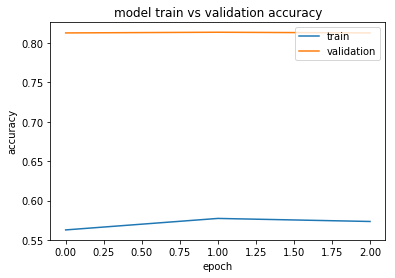

In [33]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

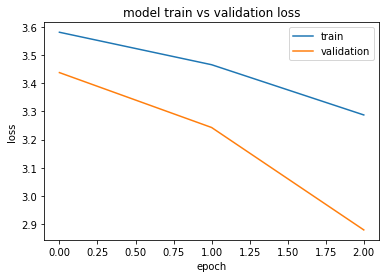

In [34]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

#### 3.6 Model Retention

In [ ]:
#save_model(model,'m_')
#with open('m_history_dict', 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)

In [35]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [51]:
def decode_sequence(input_seq, reverse_target_char_index=inv_feature_dict, max_decoder_seq_length=200,feature_dict=feature_dict):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, feature_dict['<']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '>' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [58]:

tr=labeled_data_df.iloc[1]['Notice']
tl=labeled_data_df.iloc[1]['Addresses']
tr_in=E_in[1:2]
print('Predicted Label\n',decode_sequence(tr_in))
print('Actual Label\n',tl)

Predicted Label
 777______________________________________________________________________________________________________________________________________________________________________________________________________
Actual Label
 ('311 Rosario Haven Suite 194 Jessicamouth, HI 19398', '81965 Harris Fall Suite 885 Hallhaven, WV 96622')
